In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchsummary import summary
import torch.nn.functional as F

import gpytorch

#from cuml.ensemble import RandomForestRegressor as cuRF  # not working on windows

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import BayesianRidge
#from sklearn.metrics import r2_score  # Use a torch version instead.

from scipy.stats import norm
from dataloader import load_gdsc, prepare_features, split_data
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import random

import os

import pandas as pd

import warnings
from sklearn.exceptions import ConvergenceWarning

import joblib

In [2]:
config = {
    'Name':                'Yucheng Shao',

    'random_seed':         16,
    'PCA_component':       70,        # in the inspection file, aim for 90% variance

    'surrogate':           'gp',      # 'gp', 'rf', 'bayes_linear', 'mc_dropout'
                                      # for Gaussian Process, Random Forest, and Bayesian Ridge
    
    'training_iter':       20,        # GP cannot run efficient enough, train for some iterations
    'max_train_size':      16384,     # GP cannot run efficient enough, train from a subset instead
    
    'subsample_pool_size': 16384,     # GP cannot run efficient enough, draw from a subpool instead

    'n_estimators':        100,       # RF if not efficient enough, lower this value
    
    'mc_droupout_T':       20,        # number of dropout models used, reduce for efficiency
    
    'acquisition':         'passive',    # 'passive', 'greedy', 'mcmc', 'metropolis'
    'metric':              'DBS',     # UCS for uncertainty, DBS for distance based

    'd_weight':            1,         # positive -> density based, negative -> diversity based, weight over uncertainty value
    'entropy_weight':      0.5,       # how much uncertainty is weighted relative to distance?
    'beta':                1,         # how much we want to punish/reward outliers?
    #'initial_ratio':       0.05,      # be careful when running gp, this ratio * train size (106652 for val_ration=0.2)
                                      # must be bigger or equal to batch size... or just use batch size

    'mcmc_steps':          1000,      # number of steps to average for mcmc
    
    'metropolis_steps':    50000,     # number of steps to do metropolis select, must be >> batch size

    'val_ratio':           0.2,

    'batch_size':          2048,
    'epochs':              10,
    'lr':                  0.0012,
    'weight_decay':        1e-4,
    'dropout':             0.4
}

In [3]:
config['acquisition'] = config['acquisition'].lower()
valid_acq = {'passive', 'greedy', 'mcmc', 'thompson', 'metropolis'}
if config['acquisition'] not in valid_acq:
    raise ValueError(f"Unknown acquisition type '{config['acquisition']}'. Choose from {valid_acq}")

config['surrogate'] = config['surrogate'].lower()
valid_sur = {'gp', 'rf', 'bayes_linear', 'mc_dropout'}
if config['surrogate'] not in valid_sur:
    raise ValueError(f"Unknown surrogate type '{config['surrogate']}'. Choose from {valid_sur}")

config['metric'] = config['metric'].upper()
valid_sur = {'UCS', 'DBS'}
if config['metric'] not in valid_sur:
    raise ValueError(f"Unknown surrogate type '{config['metric']}'. Choose from {valid_sur}")


assert config['subsample_pool_size'] > config['batch_size']

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed once at the beginning
set_seed(config['random_seed'])

In [5]:
excluded_columns = ['LN_IC50', 'AUC', 'Z_SCORE', 'DRUG_ID', 'COSMIC_ID', 'DRUG_NAME', 'CELL_LINE_NAME']
df = load_gdsc(excluded_columns=excluded_columns)   # With Drop NaN & Exclude Outlier with IQR

# Create dummy variables for categorical features and split the data into training and testing sets with default test size of 0.2
X_dummy, y = prepare_features(df, encode_dummies=True)
X_label, _ = prepare_features(df, encode_dummies=False)

In [6]:
# incase the sparse input under-perform
X_dummy_pca = PCA(n_components=config['PCA_component']).fit_transform(X_dummy)
# Convert back to DataFrame
X_dummy = pd.DataFrame(X_dummy_pca, columns=[f'PC{i+1}' for i in range(X_dummy_pca.shape[1])])

In [7]:
Xd_tr, Xd_te, Xl_tr, Xl_te, y_tr, y_te = split_data(X_dummy, X_label, y) 
# Xd: X features with dummy variables
# Xl: X features with label encoding (e.g. Turn R, G, B into 0, 1, 2)

In [8]:
class GPyTorchGPModel(gpytorch.models.ExactGP):  # exact GP is way too slow...
    def __init__(self, train_x, train_y, likelihood):
        super(GPyTorchGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)



def fit_gpytorch_and_predict(X_train, y_train, X_pool, seed, training_iter=20, 
                             max_train_size=config['max_train_size'],
                             checkpoint_path=f"results_{config['random_seed']}/gp_model_checkpoint.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if len(X_train) > max_train_size:
        np.random.seed(seed)
        sub_idx = np.random.choice(len(X_train), max_train_size, replace=False)
        X_train = X_train[sub_idx]
        y_train = y_train[sub_idx]

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1).to(device)
    X_pool = torch.tensor(X_pool, dtype=torch.float32).to(device)

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = GPyTorchGPModel(X_train, y_train, likelihood).to(device)

    # Attempt to load checkpoint
    if checkpoint_path and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model_key = f"gp_model_state_dict_{config['random_seed']}"
        likelihood_key = f"gp_likelihood_state_dict_{config['random_seed']}"
        if model_key in checkpoint and likelihood_key in checkpoint:
            model.load_state_dict(checkpoint[model_key])
            likelihood.load_state_dict(checkpoint[likelihood_key])
            #print(f"✔️ Loaded GP model checkpoint for seed {seed}")
        else:
            print("⚠️ Checkpoint exists but missing required keys. Retraining.")

    # Need to train in the first epoch.
    else:
        #print("🔁 No valid checkpoint found. Training from scratch...")
        model.train()
        likelihood.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for _ in range(training_iter):
            optimizer.zero_grad()
            output = model(X_train)
            loss = -mll(output, y_train)
            loss.backward()
            optimizer.step()

    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = model(X_pool)
        mu = preds.mean.cpu().numpy()
        sigma = preds.stddev.cpu().numpy()

    return mu, sigma, model, likelihood


class VariationalGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)
        

def fit_variational_gp_and_predict(X_train, y_train, X, y, X_pool, last_indices, 
                                   seed, abs_indices, training_iter=50,
                                   max_train_size=config['max_train_size'],
                                   checkpoint_path=f"results_{config['random_seed']}/vgp_model_checkpoint.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if len(abs_indices) > config['batch_size']:
        abs_indices = abs_indices[:config['batch_size']]

    # choose initial inducing points from last selected batch
    inducing_points = X[abs_indices]
    
    remaining_slots = max_train_size - len(inducing_points)
    if remaining_slots > 0:
        np.random.seed(seed)
        chosen_positions = np.random.choice(len(last_indices), min(remaining_slots, len(last_indices)), replace=False)
        additional_indices = [last_indices[i] for i in chosen_positions]
        combined_indices = list(abs_indices) + list(additional_indices)
    else:
        combined_indices = list(abs_indices)
    
    # subset
    X_train = X[combined_indices]
    y_train = y[combined_indices]

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1).to(device)
    X_pool = torch.tensor(X_pool, dtype=torch.float32).to(device)
    inducing_points = torch.tensor(inducing_points, dtype=torch.float32).to(device)
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = VariationalGPModel(inducing_points).to(device)

    # Try loading model from checkpoint
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, weights_only=True)
        model.load_state_dict(checkpoint["model"])
        likelihood.load_state_dict(checkpoint["likelihood"])
        #print(f"✔️ Loaded Variational GP model from checkpoint (seed {seed})")
    

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=0.01)

    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=X_train.size(0))

    for _ in range(training_iter):
        optimizer.zero_grad()
        output = model(X_train)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()

    # Save model
    torch.save({
        "model": model.state_dict(),
        "likelihood": likelihood.state_dict(),
    }, checkpoint_path)
    #print(f"💾 Saved Variational GP model to {checkpoint_path}")

    # Predictive mode
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = likelihood(model(X_pool))
        mu = preds.mean.cpu().numpy()
        sigma = preds.stddev.cpu().numpy()

    return mu, sigma, model, likelihood


def fit_rf_sklearn_and_predict(X_train, y_train, X_pool, seed, n_estimators=config['n_estimators'], 
                               max_train_size=config['max_train_size'],
                               checkpoint_path=f"results_{config['random_seed']}/rf_model_checkpoint.joblib"):
    if len(X_train) > max_train_size:
        np.random.seed(seed)
        sub_idx = np.random.choice(len(X_train), max_train_size, replace=False).astype(int)
        X_train = X_train[sub_idx]
        y_train = y_train[sub_idx]

    rf_model = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)

    if os.path.exists(checkpoint_path):
        rf_model = joblib.load(checkpoint_path)
        #print(f"✔️ Loaded RF model checkpoint for seed {seed}")
    else:
        rf_model.fit(X_train, y_train.ravel())
        #print(f"🔁 Trained RF model from scratch (seed {seed})")

    # Collect predictions from all trees
    preds = np.stack([tree.predict(X_pool) for tree in rf_model.estimators_], axis=0)
    
    mu = preds.mean(axis=0)
    sigma = preds.std(axis=0)

    return mu, sigma, rf_model


''' Does not work on windows!
def fit_cuml_rf_and_predict(X_train_np, y_train_np, X_pool_np, n_estimators=100):
    rf_model = cuRF(n_estimators=n_estimators)
    rf_model.fit(X_train_np, y_train_np)

    # predict from each tree for uncertainty estimation
    preds = np.stack([tree.predict(X_pool_np) for tree in rf_model.base_models_], axis=0)
    mu = preds.mean(axis=0)
    sigma = preds.std(axis=0)
    return mu, sigma
'''


def fit_bayes_linear_and_predict(X_train, y_train, X_pool, seed, 
                                 max_train_size=config['max_train_size'],
                                 checkpoint_path=f"results_{config['random_seed']}/bl_model_checkpoint.joblib"):
    if len(X_train) > max_train_size:
        np.random.seed(seed)
        sub_idx = np.random.choice(len(X_train), max_train_size, replace=False).astype(int)
        X_train = X_train[sub_idx]
        y_train = y_train[sub_idx]
    
    bl_model = BayesianRidge()
    if os.path.exists(checkpoint_path):
        bl_model = joblib.load(checkpoint_path)
        #print(f"✔️ Loaded Bayesian Linear model checkpoint for seed {seed}")
    else:
        bl_model.fit(X_train, y_train.ravel())
        #print(f"🔁 Trained Bayesian Linear model from scratch (seed {seed})")
    mu, sigma = bl_model.predict(X_pool, return_std=True)
    return mu, sigma, bl_model


def enable_dropout(nn_model):
    """Enable dropout during inference."""
    for m in nn_model.modules():
        if isinstance(m, nn.Dropout):
            m.train()


def fit_mc_dropout_and_predict(nn_model, X, T=config['mc_droupout_T']):
    nn_model.eval()
    enable_dropout(nn_model)

    device = next(nn_model.parameters()).device

    X = torch.tensor(X, dtype=torch.float32).to(device)

    preds = []

    with torch.no_grad():
        for _ in range(T):
            pred = nn_model(X)
            preds.append(pred.cpu().numpy())

    preds = np.stack(preds, axis=0)  # shape: (T, batch_size, 1)
    mu = preds.mean(axis=0).squeeze()   # mean prediction
    sigma = preds.std(axis=0).squeeze() # uncertainty (std)

    return mu, sigma

#mu, sigma = fit_gpytorch_and_predict(X_train, y_train, X_pool)

In [9]:
'''Define Acquisition Methods'''
# Passive acquisition (random sampling)
def select_next_batch_passive(X_pool, batch_size):
    selected = np.random.choice(len(X_pool), batch_size, replace=False)
    return selected
    

'''There is a mistake in the _opt methods. They were meant to select for optimization, not regression training.'''
# Greedy acquisition
def select_next_batch_greedy_opt(X_pool, y_pool, mu, sigma, batch_size):
    best_y = np.min(y_pool)
    improvement = best_y - mu
    Z = improvement / (sigma + 1e-8)
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    selected = np.argsort(ei)[-batch_size:]
    return selected
    

# MCMC acquisition
def select_next_batch_mcmc_opt(X_pool, mu, sigma, batch_size, steps=config['mcmc_steps']):
    scores = mu + np.random.normal(0, sigma, size=(steps, len(X_pool)))   # sample from N steps times
    selected = np.argsort(np.mean(scores, axis=0))[-batch_size:]
    return selected


# Thompson Sampling
def select_next_batch_thompson_opt(X_pool, mu, sigma, batch_size):
    samples = np.random.normal(mu, sigma)
    selected = np.argsort(samples)[-batch_size:]
    return selected
    

# Metropolis-Hastings acquisition
def select_next_batch_metropolis_opt(X_pool, mu, sigma, batch_size, steps=config['metropolis_steps']):
    n = len(mu)
    selected = set()
    available_indices = set(range(n))

    # Initialize with a random index
    current_idx = np.random.choice(list(available_indices))
    selected.add(current_idx)
    available_indices.remove(current_idx)

    for _ in range(steps):
        if len(selected) >= batch_size:
            break
        if not available_indices:
            break  # pool exhausted

        candidate_idx = np.random.choice(list(available_indices))

        sample_current = np.random.normal(mu[current_idx], sigma[current_idx])
        sample_candidate = np.random.normal(mu[candidate_idx], sigma[candidate_idx])

        # Favor candidates with lower sample values
        p_accept = min(1, (sample_current + 1e-6) / (sample_candidate + 1e-6))

        if np.random.rand() < p_accept:
            selected.add(candidate_idx)
            available_indices.remove(candidate_idx)
            current_idx = candidate_idx  # move to accepted

    return np.array(list(selected))

In [10]:
'''Define different metrics used for selection.'''
def uncertainty_entropy_metric(mu, sigma, **kwargs):  # type I
    return sigma


from sklearn.metrics.pairwise import euclidean_distances


def distance_based_metric(mu, sigma, X_pool=None, d_weight=config['d_weight'], 
                          entropy_weight=config['entropy_weight'], beta=config['beta'], **kwargs):  # mixed
    assert X_pool is not None
    # X_pool is required for density/diversity-based metrics

    # Euclidean distance for similarity
    distance_matrix = euclidean_distances(X_pool, X_pool)
    np.fill_diagonal(distance_matrix, np.inf)  # ignore self-distance
    similarity_matrix = np.sum(1 / (distance_matrix + 1e-8), axis=1)

    # Normalize both
    sigma = (sigma - np.min(sigma)) / (np.max(sigma) - np.min(sigma) + 1e-8)
    similarity_score = (similarity_matrix - np.min(similarity_matrix)) / (np.max(similarity_matrix) - np.min(similarity_matrix) + 1e-8)

    similarity_score = d_weight * similarity_score
    
    score = entropy_weight * sigma + (1 - entropy_weight) * similarity_score**beta
    return score

In [11]:
'''Define acquisition functions here using the different selection metrics defined earlier.'''
# Greedy acquisition
def select_next_batch_greedy(X_pool, mu, sigma, batch_size, metric_fn):
    entropy_vector = metric_fn(mu=mu, sigma=sigma, X_pool=X_pool)
    # not necessary entropy... just a vector of how much info we believe the instance has
    # based on what ever metric we chose
    selected = np.argsort(entropy_vector)[-batch_size:]
    return selected


# MCMC acquisition
# mimic epistemic uncertainty
def select_next_batch_mcmc(X_pool, mu, sigma, batch_size, metric_fn, steps=config['mcmc_steps']):
    entropy_vecotor = metric_fn(mu=mu, sigma=sigma, X_pool=X_pool)
    samples = entropy_vecotor[:, None] * np.random.randn(len(X_pool), steps)
    # samples from defined uncertainty / information metrics many times to mimic epistemic uncertainty
    sampled_vars = np.var(samples, axis=1)

    selected = np.argsort(sampled_vars)[-batch_size:]
    return selected


# No more Thompson, since it is nothing more than a Greedy approach.
# Metropolis-Hastings acquisition
def select_next_batch_metropolis(X_pool, mu, sigma, batch_size, metric_fn, steps=config['metropolis_steps']):
    n = len(mu)
    selected = set()
    available_indices = set(range(n))

    entropy_vecotor = metric_fn(mu=mu, sigma=sigma, X_pool=X_pool)

    # Initialize with a random index
    current_idx = np.random.choice(list(available_indices))
    selected.add(current_idx)
    available_indices.remove(current_idx)

    for _ in range(steps):
        if len(selected) >= batch_size:
            break
        if not available_indices:
            break  # pool exhausted

        candidate_idx = np.random.choice(list(available_indices))

        # Sample from each metric-based "distribution" to simulate stochastic decision
        sample_current = np.random.normal(loc=entropy_vecotor[current_idx], scale=1.0)
        sample_candidate = np.random.normal(loc=entropy_vecotor[candidate_idx], scale=1.0)

        # Higher information (entropy) is better ⇒ favor larger sample
        p_accept = min(1, (sample_candidate + 1e-6) / (sample_current + 1e-6))

        if np.random.rand() < p_accept:
            selected.add(candidate_idx)
            available_indices.remove(candidate_idx)
            current_idx = candidate_idx  # move to accepted

    return np.array(list(selected))

In [12]:
'''Define Learning Loop'''
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


os.makedirs(f"results_{config['random_seed']}", exist_ok=True)


def gp_active_learning_loop(X, y, seed, nn_model, #initial_ratio=0.01,  can just use batch size for first batch
                            batch_size=config['batch_size'], acquisition=config['acquisition'],
                            metric=config['metric']):
    n_samples = X.shape[0]
    initial_size = batch_size  #int(initial_ratio * n_samples)
    all_indices = np.arange(n_samples)
    np.random.shuffle(all_indices)
    selected_indices = list(all_indices[:initial_size])
    remaining_indices = all_indices[initial_size:]
    last_indices = []
    abs_indices = selected_indices

    total_batches = len(remaining_indices) // batch_size

    with tqdm(total=total_batches, desc=f"Active Learning ({acquisition})") as pbar:
    #for _ in range(total_batches):
        while len(remaining_indices) >= batch_size:
            subsample_size = min(config.get('subsample_pool_size', 10000), len(remaining_indices))
            sub_pool_rel_indices = np.random.choice(len(remaining_indices), subsample_size, replace=False)
            sub_pool_abs_indices = remaining_indices[sub_pool_rel_indices]

            X_pool = X[sub_pool_abs_indices]
            y_pool = y[sub_pool_abs_indices]
            

            X_train, y_train = X[selected_indices], y[selected_indices]
            # define GP model here for acquisiton methods
            if acquisition != 'passive':
                if config['surrogate'] == 'gp':
                    # need to check if the s_model and s_likelihood with that random seed exist (if the gp model already trained)
                    # and need to load it here if so
                    checkpoint_path = (f"results_{config['random_seed']}/{config['surrogate']}_{config['metric']}_{config['acquisition']}_"
                                       f"rnd{config['random_seed']}_model_checkpoint.pth")
                    mu, sigma, gp_model, gp_likelihood = fit_variational_gp_and_predict(X_train, y_train, X, y, X_pool, last_indices, seed,
                                                                                        abs_indices=abs_indices,
                                                                                        training_iter=config['training_iter'],
                                                                                        max_train_size=config['max_train_size'],
                                                                                        checkpoint_path=checkpoint_path)

                elif config['surrogate'] == 'rf':
                    checkpoint_path = (f"results_{config['random_seed']}/{config['surrogate']}_{config['metric']}_{config['acquisition']}_"
                                       f"rnd{config['random_seed']}_model_checkpoint.joblib")
                    mu, sigma, rf_model = fit_rf_sklearn_and_predict(X_train, y_train, X_pool, seed,
                                                                     n_estimators=config['n_estimators'],
                                                                     max_train_size=config['max_train_size'],
                                                                     checkpoint_path=checkpoint_path)

                elif config['surrogate'] == 'bayes_linear':
                    checkpoint_path = (f"results_{config['random_seed']}/{config['surrogate']}_{config['metric']}_{config['acquisition']}_"
                                       f"rnd{config['random_seed']}_model_checkpoint.joblib")
                    mu, sigma, bl_model = fit_bayes_linear_and_predict(X_train, y_train, X_pool, seed,
                                                                       max_train_size=config['max_train_size'],
                                                                       checkpoint_path=checkpoint_path)

                elif config['surrogate'] == 'mc_dropout':  # must use X_pool here
                    mu, sigma = fit_mc_dropout_and_predict(nn_model, X_pool, T=config['mc_droupout_T'])

                else:
                    raise ValueError(f"Unknown surrogate model: {config['surrogate']}")

            
            if len(X_pool) <= batch_size:
                # if not enough data left... no need to do selection anymore 
                # just take all remaining data (but still need to let gp model see all data in order to reuse the best model)
                selected_indices.extend(sub_pool_abs_indices)
                break           

            if metric == 'UCS':
                metric_fn = uncertainty_entropy_metric
            elif metric == 'DBS':
                metric_fn = distance_based_metric


            if acquisition == 'passive':
                rel_indices = select_next_batch_passive(X_pool, batch_size)  # no need surrogate model
            elif acquisition == 'greedy':
                rel_indices = select_next_batch_greedy(X_pool, mu, sigma, batch_size, metric_fn)
            elif acquisition == 'mcmc':
                rel_indices = select_next_batch_mcmc(X_pool, mu, sigma, batch_size, metric_fn)
            #elif acquisition == 'thompson':  no longer using this
            #    rel_indices = select_next_batch_thompson(X_pool, mu, sigma, batch_size)
            elif acquisition == 'metropolis':
                rel_indices = select_next_batch_metropolis(X_pool, mu, sigma, batch_size, metric_fn)
                
            else:
                raise ValueError('unknown acquisiton type')
            #print(len(rel_indices))
            if len(rel_indices) < config['batch_size']:
                print(f"warning, undersampling detected: {len(rel_indices)} number sampled")

            #print("X_pool.shape:", X_pool.shape)
            #print("mu.shape:", mu.shape)
            #print("sigma.shape:", sigma.shape)
            #print("rel_indices.max():", rel_indices.max())
        
            abs_indices = sub_pool_abs_indices[rel_indices]
            last_indices = selected_indices.copy()

            selected_indices.extend(abs_indices)
            remaining_indices = np.setdiff1d(remaining_indices, abs_indices)

            pbar.update(1)

    if acquisition != 'passive':
        #and max_train_size >= len(X_train):  # we can reuse model if we trained on all data
        # impossible to run down all samples... vram ran out, just figure out the best I can do
        # it makes no sense to retain the model over and over though...
        #if config['surrogate'] == 'gp':
        #    print(f"💾 Saving trained GP model (seed {config['random_seed']}) since full training data was used.")
        #    torch.save({
        #    f"gp_model_state_dict_{config['random_seed']}": gp_model.state_dict(),
        #    f"gp_likelihood_state_dict_{config['random_seed']}": gp_likelihood.state_dict(),
        #    }, f"results_{config['random_seed']}/gp_model_checkpoint.pth")
        # this is done inside the variational gp loop

        if config['surrogate'] == 'rf':
            print(f"💾 Saving trained Random Forest (seed {config['random_seed']})")
            joblib.dump(rf_model, checkpoint_path)

        elif config['surrogate'] == 'bayes_linear':
            print(f"💾 Saving trained Bayesian Linear model (seed {config['random_seed']})")
            joblib.dump(bl_model, checkpoint_path)

    X_final = X[selected_indices]
    y_final = y[selected_indices]
    dataset = RegressionDataset(X_final, y_final)

    # we do not want to shuffle in this case since we just made and ordered the batches based on acquisition
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Simple sparse-aware MLP
class SparseRegressor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [14]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to tensors and normalize
Xd_tr_tensor = torch.tensor(Xd_tr.to_numpy(), dtype=torch.float32)
Xd_te_tensor = torch.tensor(Xd_te.to_numpy(), dtype=torch.float32)
y_tr_tensor = torch.tensor(y_tr.to_numpy(), dtype=torch.float32).unsqueeze(1)
y_te_tensor = torch.tensor(y_te.to_numpy(), dtype=torch.float32).unsqueeze(1)

scaler = StandardScaler()
Xd_tr_tensor = torch.tensor(scaler.fit_transform(Xd_tr_tensor), dtype=torch.float32)
Xd_te_tensor = torch.tensor(scaler.transform(Xd_te_tensor), dtype=torch.float32)

# Dataset and DataLoader
train_dataset = TensorDataset(Xd_tr_tensor, y_tr_tensor)
test_dataset = TensorDataset(Xd_te_tensor, y_te_tensor)

# Split into train and val
val_ratio = config['val_ratio']
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Unpack tensors from train_dataset (already normalized + tensorized)
train_X_tensor, train_y_tensor = zip(*train_dataset)

# Stack and convert to NumPy arrays for GP input
Xd_tr_np = torch.stack(train_X_tensor).cpu().numpy()
y_tr_np = torch.stack(train_y_tensor).squeeze().cpu().numpy()

print(Xd_tr_np.shape)

#train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
# Do not shuffle, the randomness came from inside the loop.
# Need to reload the model each epoch so the batch order is not part of the learning.
'''train_loader = gp_active_learning_loop(Xd_tr_np, y_tr_np,  # ← Xd_tr and y_tr as NumPy arrays
                                       config['random_seed'],
                                       #initial_ratio=config['initial_ratio'],
                                       batch_size=config['batch_size'],
                                       acquisition=config['acquisition'])'''

val_loader   = DataLoader(val_dataset, batch_size=config['batch_size'])
test_loader  = DataLoader(test_dataset, batch_size=config['batch_size'])

(106652, 70)


In [15]:
'''
ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-10. 
Decreasing the bound and calling fit again may find a better value.
'''

'\nConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-10. \nDecreasing the bound and calling fit again may find a better value.\n'

In [16]:
# Model setup
input_dim = Xd_tr.shape[1]
nn_model = SparseRegressor(input_dim, dropout_rate=config['dropout']).to(device)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
criterion = nn.MSELoss()

summary(nn_model, input_size=(input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          18,176
       BatchNorm1d-2                  [-1, 256]             512
              GELU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
       BatchNorm1d-6                  [-1, 128]             256
              GELU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
             GELU-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 60,161
Trainable params: 60,161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [17]:
def compute_rmse(pred, true):  # do not use this since loss is already MSE
    return torch.sqrt(F.mse_loss(pred, true)).item()


def compute_r2(pred, true):
    ss_res = torch.sum((true - pred) ** 2)
    ss_tot = torch.sum((true - torch.mean(true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2.item()
    

def train_model(nn_model, val_loader, test_loader, epochs=30):
    
    train_losses, val_losses, test_losses = [], [], []
    train_r2s, val_r2s, test_r2s = [], [], []

    for epoch in range(epochs):

        seed = config['random_seed'] + epoch  # different seed per epoch

        train_loader = gp_active_learning_loop(
            Xd_tr_np, y_tr_np,
            seed,
            nn_model,
            #initial_ratio=config['initial_ratio'],
            batch_size=config['batch_size'],
            acquisition=config['acquisition']
        )
        
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False)
        for x_batch, y_batch in train_loop:
            nn_model.train()
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = nn_model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            r2 = compute_r2(preds, y_batch)
            train_losses.append(loss.item())
            train_r2s.append(r2)
            train_loop.set_postfix(loss=loss.item(), r2=r2)

            # Validation (per batch)
            nn_model.eval()
            #val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", leave=False)
            total_val_loss = 0.0
            total_val_r2 = 0.0
            with torch.no_grad():
                #for x_val, y_val in val_loop:
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    preds = nn_model(x_val)
                    loss = criterion(preds, y_val)
                    r2 = compute_r2(preds, y_val)
                    total_val_loss += loss.item() * x_val.size(0)
                    total_val_r2 += r2 * x_val.size(0)

            avg_val_loss = total_val_loss / len(val_loader.dataset)
            avg_val_r2 = total_val_r2 / len(val_loader.dataset)
            val_losses.append(avg_val_loss)
            val_r2s.append(avg_val_r2)
            #val_loop.set_postfix(loss=loss.item(), r2=r2)

            # Test (per batch)
            #test_loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} - Test", leave=False)
            total_test_loss = 0.0
            total_test_r2 = 0.0
            with torch.no_grad():
                #for x_test, y_test in test_loop:
                for x_test, y_test in test_loader:
                    x_test, y_test = x_test.to(device), y_test.to(device)
                    preds = nn_model(x_test)
                    loss = criterion(preds, y_test)
                    r2 = compute_r2(preds, y_test)
                    total_test_loss += loss.item() * x_test.size(0)
                    total_test_r2 += r2 * x_test.size(0)

            avg_test_loss = total_test_loss / len(test_loader.dataset)
            avg_test_r2 = total_test_r2 / len(test_loader.dataset)
            test_losses.append(avg_test_loss)
            test_r2s.append(avg_test_r2)
            #test_loop.set_postfix(loss=loss.item(), r2=r2)

        print(f"Epoch {epoch+1:02d} | "
              f"Last Batch -> Train Loss: {train_losses[-1]:.4f}, R^2: {train_r2s[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f}, R^2: {val_r2s[-1]:.4f} | "
              f"Test Loss: {test_losses[-1]:.4f}, R^2: {test_r2s[-1]:.4f}")

    return {
        "train_loss": train_losses, "val_loss": val_losses, "test_loss": test_losses,
        "train_r2": train_r2s, "val_r2": val_r2s, "test_r2": test_r2s
    }

In [18]:
results = train_model(nn_model, val_loader, test_loader, epochs=config['epochs'])

Active Learning (passive): 100%|███████████████████████████████████████████████████████| 51/51 [00:01<00:00, 26.83it/s]


Epoch 01 | Last Batch -> Train Loss: 5.6305, R^2: 0.2258 | Val Loss: 6.0177, R^2: 0.1578 | Test Loss: 6.0315, R^2: 0.1442


Active Learning (passive): 100%|███████████████████████████████████████████████████████| 51/51 [00:01<00:00, 29.23it/s]


Epoch 02 | Last Batch -> Train Loss: 5.3548, R^2: 0.2433 | Val Loss: 5.4510, R^2: 0.2372 | Test Loss: 5.4479, R^2: 0.2269


Active Learning (passive): 100%|███████████████████████████████████████████████████████| 51/51 [00:01<00:00, 28.77it/s]


Epoch 03 | Last Batch -> Train Loss: 5.2862, R^2: 0.2709 | Val Loss: 5.2547, R^2: 0.2647 | Test Loss: 5.2550, R^2: 0.2543


Active Learning (passive): 100%|███████████████████████████████████████████████████████| 51/51 [00:01<00:00, 29.69it/s]


Epoch 04 | Last Batch -> Train Loss: 4.8360, R^2: 0.2777 | Val Loss: 5.1395, R^2: 0.2809 | Test Loss: 5.1321, R^2: 0.2717


Active Learning (passive): 100%|███████████████████████████████████████████████████████| 51/51 [00:01<00:00, 29.19it/s]


Epoch 05 | Last Batch -> Train Loss: 5.1766, R^2: 0.2521 | Val Loss: 5.0787, R^2: 0.2894 | Test Loss: 5.0772, R^2: 0.2796


Active Learning (passive): 100%|███████████████████████████████████████████████████████| 51/51 [00:01<00:00, 27.30it/s]


Epoch 06 | Last Batch -> Train Loss: 5.0800, R^2: 0.2825 | Val Loss: 5.0475, R^2: 0.2938 | Test Loss: 5.0474, R^2: 0.2838


Active Learning (passive): 100%|███████████████████████████████████████████████████████| 51/51 [00:01<00:00, 27.44it/s]


Epoch 07 | Last Batch -> Train Loss: 5.1681, R^2: 0.2716 | Val Loss: 5.0021, R^2: 0.3002 | Test Loss: 4.9948, R^2: 0.2913


Active Learning (passive): 100%|███████████████████████████████████████████████████████| 51/51 [00:01<00:00, 27.34it/s]


Epoch 08 | Last Batch -> Train Loss: 4.9731, R^2: 0.2864 | Val Loss: 4.9774, R^2: 0.3036 | Test Loss: 4.9724, R^2: 0.2944


Active Learning (passive): 100%|███████████████████████████████████████████████████████| 51/51 [00:01<00:00, 25.87it/s]


Epoch 09 | Last Batch -> Train Loss: 5.0213, R^2: 0.2945 | Val Loss: 4.9416, R^2: 0.3087 | Test Loss: 4.9365, R^2: 0.2995


Active Learning (passive): 100%|███████████████████████████████████████████████████████| 51/51 [00:01<00:00, 25.74it/s]
                                                                                                                       

Epoch 10 | Last Batch -> Train Loss: 4.8863, R^2: 0.3114 | Val Loss: 4.9360, R^2: 0.3095 | Test Loss: 4.9292, R^2: 0.3006


In [19]:
# each epoch has 52 batches for batch size 2048
np.savez(f"results_{config['random_seed']}/history_{config['surrogate']}_{config['metric']}_{config['acquisition']}_rnd{config['random_seed']}.npz", **results)

In [20]:
torch.save(nn_model.state_dict(), f"results_{config['random_seed']}/model_{config['surrogate']}_{config['metric']}_{config['acquisition']}_rnd{config['random_seed']}.pt")

'''model = SparseRegressor(input_dim).to(device)
model.load_state_dict(torch.load(f"checkpoints/model_{config['acquisition']}_seed{config['random_seed']}.pt"))
model.eval()'''

'model = SparseRegressor(input_dim).to(device)\nmodel.load_state_dict(torch.load(f"checkpoints/model_{config[\'acquisition\']}_seed{config[\'random_seed\']}.pt"))\nmodel.eval()'

In [21]:
loaded = np.load(f"results_{config['random_seed']}/history_{config['surrogate']}_{config['metric']}_{config['acquisition']}_rnd{config['random_seed']}.npz")
print(loaded["train_r2"].shape)

results = {k: list(loaded[k]) for k in loaded.files}

(520,)


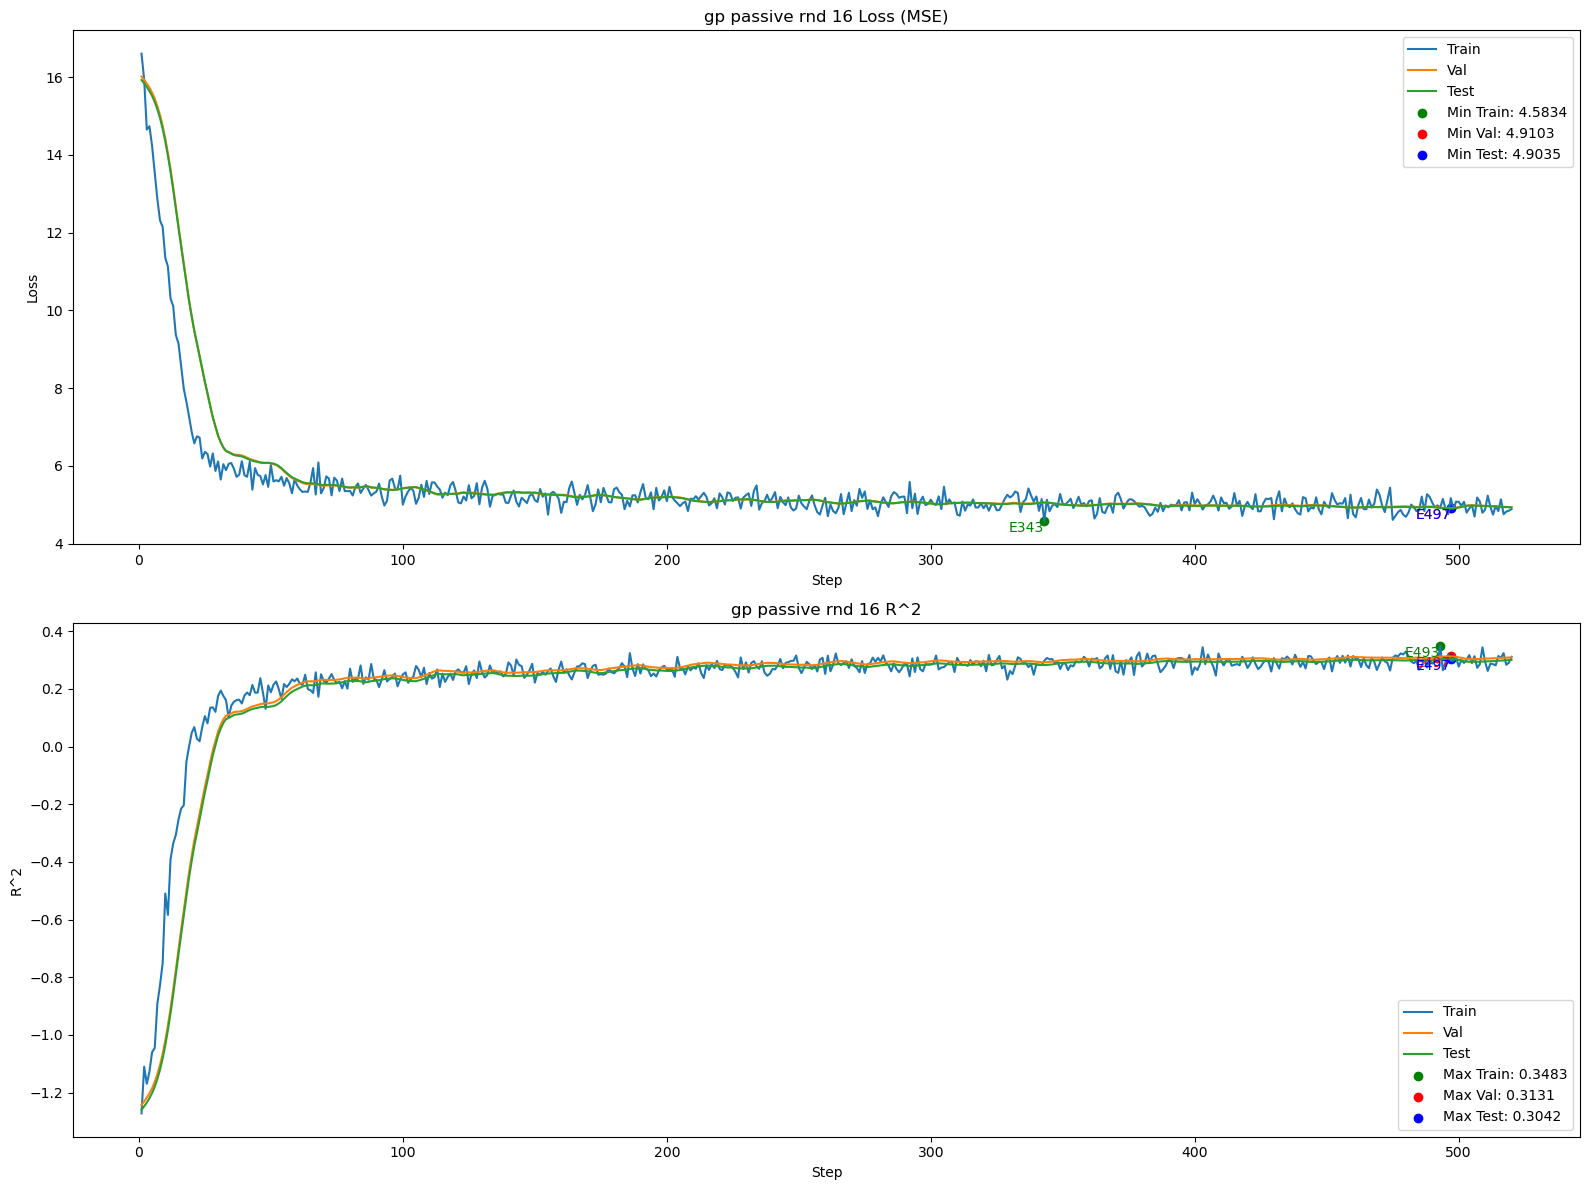

In [22]:
steps = list(range(1, len(results["train_loss"]) + 1))

# Get min values and corresponding steps
def get_min_metric(metric):
    value = min(metric)
    steps = metric.index(value) + 1
    return value, steps


# Get max values and corresponding steps
def get_max_metric(metric):
    value = max(metric)
    steps = metric.index(value) + 1
    return value, steps


min_train_loss, ep_train_loss = get_min_metric(results["train_loss"])
min_val_loss, ep_val_loss     = get_min_metric(results["val_loss"])
min_test_loss, ep_test_loss   = get_min_metric(results["test_loss"])

max_train_r2, ep_train_r2 = get_max_metric(results["train_r2"])
max_val_r2, ep_val_r2     = get_max_metric(results["val_r2"])
max_test_r2, ep_test_r2   = get_max_metric(results["test_r2"])

plt.figure(figsize=(16, 12))

# --- Loss Plot ---
plt.subplot(2, 1, 1)
plt.plot(steps, results["train_loss"], label="Train")
plt.plot(steps, results["val_loss"], label="Val")
plt.plot(steps, results["test_loss"], label="Test")

# Mark min points for Loss
plt.scatter(ep_train_loss, min_train_loss, color='green', label=f"Min Train: {min_train_loss:.4f}")
plt.text(ep_train_loss, min_train_loss, f"E{ep_train_loss}", color='green', va='top', ha='right')

plt.scatter(ep_val_loss, min_val_loss, color='red', label=f"Min Val: {min_val_loss:.4f}")
plt.text(ep_val_loss, min_val_loss, f"E{ep_val_loss}", color='red', va='top', ha='right')

plt.scatter(ep_test_loss, min_test_loss, color='blue', label=f"Min Test: {min_test_loss:.4f}")
plt.text(ep_test_loss, min_test_loss, f"E{ep_test_loss}", color='blue', va='top', ha='right')

plt.title(f"{config['surrogate']} {config['acquisition']} rnd {config['random_seed']} Loss (MSE)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()

# --- R^2 Plot ---
plt.subplot(2, 1, 2)
plt.plot(steps, results["train_r2"], label="Train")
plt.plot(steps, results["val_r2"], label="Val")
plt.plot(steps, results["test_r2"], label="Test")

# Mark max points for R^2
plt.scatter(ep_train_r2, max_train_r2, color='green', label=f"Max Train: {max_train_r2:.4f}")
plt.text(ep_train_r2, max_train_r2, f"E{ep_train_r2}", color='green', va='top', ha='right')

plt.scatter(ep_val_r2, max_val_r2, color='red', label=f"Max Val: {max_val_r2:.4f}")
plt.text(ep_val_r2, max_val_r2, f"E{ep_val_r2}", color='red', va='top', ha='right')

plt.scatter(ep_test_r2, max_test_r2, color='blue', label=f"Max Test: {max_test_r2:.4f}")
plt.text(ep_test_r2, max_test_r2, f"E{ep_test_r2}", color='blue', va='top', ha='right')

plt.title(f"{config['surrogate']} {config['acquisition']} rnd {config['random_seed']} R^2")
plt.xlabel("Step")
plt.ylabel("R^2")
plt.legend()

plt.tight_layout()
plt.show()